In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import sys

In [56]:
# Función para cargar datos desde un archivo CSV o Excel
def cargar_datos(ruta_archivo):
    """
    Carga datos de registros de pozo desde un archivo CSV o Excel.
    
    Args:
        ruta_archivo (str): Ruta al archivo que contiene los datos.
        
    Returns:
        pandas.DataFrame: DataFrame con los datos de registros.
    """
    if ruta_archivo.endswith('.csv'):
        df = pd.read_csv(ruta_archivo, sep=";", na_values=["NA", "NaN", "-999.25", -999.25])
        df.dropna(inplace=True)
    elif ruta_archivo.endswith(('.xlsx', '.xls')):
        df = pd.read_excel(ruta_archivo)
    else:
        raise ValueError("Formato de archivo no soportado. Use CSV o Excel.")
    
    #Extraer nombre de pozo
    nombre_archivo = os.path.basename(ruta_archivo)
    nombre_pozo = os.path.splitext(nombre_archivo)[0]
    
    df["well"]= nombre_pozo
    
    print(f"Columnas disponibles: {df.columns.tolist()}")
    return df

In [57]:
# Función para calcular volumen de arcilla con el método de rayos gamma
def calcular_vsh_gr(df, gr_columna, gr_min=None, gr_max=None):
    """
    Calcula el volumen de arcilla usando el método de rayos gamma.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        gr_columna (str): Nombre de la columna que contiene el registro GR.
        gr_min (float, optional): Valor mínimo de GR (arena limpia). Si es None, se calcula del percentil 5.
        gr_max (float, optional): Valor máximo de GR (arcilla). Si es None, se calcula del percentil 95.
        
    Returns:
        pandas.Series: Serie con los valores de volumen de arcilla calculados.
    """
    # Si no se proporcionan valores, calcular automáticamente
    if gr_min is None:
        gr_min = df[gr_columna].quantile(0.05)
    if gr_max is None:
        gr_max = df[gr_columna].quantile(0.95)
    
    print(f"GR min (arena limpia): {gr_min:.2f}")
    print(f"GR max (arcilla): {gr_max:.2f}")
    
    # Índice de rayos gamma lineal
    igr = (df[gr_columna] - gr_min) / (gr_max - gr_min)
    igr = igr.clip(0, 1)  # Restringir valores entre 0 y 1
    
    # Calcular Vsh con diferentes ecuaciones
    vsh_linear = igr.copy()
    
    # Ecuación de Larionov para rocas terciarias
    #vsh_larionov_ter = 0.083 * (2**(3.7 * igr) - 1)
    
    # Ecuación de Larionov para rocas más antiguas
    vsh_larionov_old = 0.33 * (2**(2 * igr) - 1)
    
    # Ecuación de Clavier
    vsh_clavier = 1.7 - np.sqrt(3.38 - (igr + 0.7)**2)
    
    # Ecuación de Steiber
    vsh_steiber = igr / (3 - 2 * igr)
    
    #Usar el metodo moda para la litologia
    df_temp = pd.DataFrame({
        "vsh_linear": vsh_linear,
        "vsh_larionov_old": vsh_larionov_old,
        #"vsh_larionov_ter": vsh_larionov_ter,
        "vsh_clavier": vsh_clavier,
        "vsh_steiber": vsh_steiber
    })
    
    vsh_moda = df_temp.round(2).mode(axis=1)[0]
    
    
    # Crear un DataFrame con todos los resultados
    results = pd.DataFrame({
        'VSH_Linear_GR': vsh_linear,
        #'VSH_Larionov_Terciario_GR': vsh_larionov_ter,
        'VSH_Larionov_old_GR': vsh_larionov_old,
        'VSH_Clavier_GR': vsh_clavier,
        'VSH_Steiber_GR': vsh_steiber,
        'VSH_Moda_GR': vsh_moda
    })
    
    return results

In [58]:
# Función para calcular volumen de arcilla con el método de resistividad
def calcular_vsh_res(df, res_columna, res_arena=None, res_arcilla=None):
    """
    Calcula el volumen de arcilla usando el método de resistividad.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        res_columna (str): Nombre de la columna que contiene el registro de resistividad somera.
        res_arena (float, optional): Valor de resistividad para arena limpia. Si es None, se calcula del percentil 95.
        res_arcilla (float, optional): Valor de resistividad para arcilla. Si es None, se calcula del percentil 5.
        
    Returns:
        pandas.Series: Serie con los valores de volumen de arcilla calculados.
    """
    # Si no se proporcionan valores, calcular automáticamente
    if res_arena is None:
        res_arena = df[res_columna].quantile(0.95)
    if res_arcilla is None:
        res_arcilla = df[res_columna].quantile(0.05)
    
    print(f"Resistividad de arena limpia: {res_arena:.2f} ohm-m")
    print(f"Resistividad de arcilla: {res_arcilla:.2f} ohm-m")
    
    # Modelo de Simandoux simplificado (Resistivity Index Method)
    # Vsh = (log(Rt) - log(Rsand)) / (log(Rshale) - log(Rsand))
    rt = df[res_columna]
    
    # Evitar valores negativos o cero en resistividad
    rt = rt.clip(lower=0.0001)
    
    # Calcular Vsh usando logaritmos
    log_rt = np.log10(rt)
    log_res_arena = np.log10(res_arena)
    log_res_arcilla = np.log10(res_arcilla)
    
    vsh_res = (log_rt - log_res_arena) / (log_res_arcilla - log_res_arena)
    
    # La fórmula arriba da valores altos para arenas y bajos para arcillas, hay que invertir
    #vsh_res = 1 - vsh_res
    
    # Limitar los valores entre 0 y 1
    vsh_res = vsh_res.clip(0, 1)
    
    return vsh_res

In [59]:
# Función para calcular volumen de arcilla con el método de neutrón-densidad
def calcular_vsh_nd(df, nphi_columna, rhob_columna, nphi_matriz=0, rhob_matriz=2.65, 
                   nphi_arcilla=0.45, rhob_arcilla=2.45):
    """
    Calcula el volumen de arcilla usando el método de neutrón-densidad.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        nphi_columna (str): Nombre de la columna que contiene el registro de neutrón.
        rhob_columna (str): Nombre de la columna que contiene el registro de densidad.
        nphi_matriz (float): Valor de porosidad de neutrón para la matriz.
        rhob_matriz (float): Valor de densidad para la matriz.
        nphi_arcilla (float): Valor de porosidad de neutrón para la arcilla.
        rhob_arcilla (float): Valor de densidad para la arcilla.
        
    Returns:
        pandas.Series: Serie con los valores de volumen de arcilla calculados.
    """
    # Calcular el volumen de arcilla
    numerador = (df[nphi_columna] - nphi_matriz) - (rhob_matriz - df[rhob_columna]) * ((nphi_matriz - nphi_arcilla) / (rhob_matriz - rhob_arcilla))
    denominador = nphi_arcilla - nphi_matriz - (rhob_matriz - rhob_arcilla) * ((nphi_matriz - nphi_arcilla) / (rhob_matriz - rhob_arcilla))
    
    vsh_nd = numerador / denominador
    vsh_nd = vsh_nd.clip(0, 1)  # Restringir valores entre 0 y 1
    
    return vsh_nd

In [60]:
#Funcion para calcular volumen de arcilla con el metodo sonico
def calcular_vsh_dt(df, dt_columna, dt_matriz=None, dt_arcilla=None):
    """
    Calcula el volumen de arcilla usando el metodo del tiempo de transito sonico
    
    Args:
    df (pandas.DataFrame): DataFrame con los datos de registros.
    dt_columna (str): Nombre de la columna que contiene el registro DT.
    dt_matriz (float, optional): Valor de tiempo de transito para la matriz. Si es None, se calcula del percentil 5.
    dt_arcilla (float, optional): Valor de tiempo de transito para la arcilla. Si es None, se calcula del percentil 95.
    
    Returns:
    pandas.Series: Serie con los valores de volumen de arcilla calculados.
    """
    # Si no se proporcionan valores, calcular automáticamente
    if dt_matriz is None:
        dt_matriz = df[dt_columna].quantile(0.05) #valores bajos para arena limpia
    if dt_arcilla is None:
        dt_arcilla = df[dt_columna].quantile(0.95) #valores altos para arcilla
        
    print(f"DT matriz (arena limpia): {dt_matriz:.2f} ms/ft")
    print(f"DT arcilla: {dt_arcilla:.2f} ms/ft")
    
    #Metodo lineal de tiempo de transito
    vsh_dt_lineal = (df[dt_columna] - dt_matriz) / (dt_arcilla - dt_matriz)
    vsh_dt_lineal = vsh_dt_lineal.clip(0, 1)  # Restringir valores entre 0 y 1
    
    #Metodo ajustado para formaciones compactadas (variante de larionov)
    #Este metodo es util para formaciones mas consolidadas
    vsh_dt_ajustado = 0.33 * (2**(2 * vsh_dt_lineal) - 1)
    vsh_dt_ajustado = vsh_dt_ajustado.clip(0, 1)  # Restringir valores entre 0 y 1
    
    #Metodo de Clavier para sonico
    vsh_dt_clavier = 1.7 - np.sqrt(3.38 - (vsh_dt_lineal + 0.7)**2)
    vsh_dt_clavier = vsh_dt_clavier.clip(0, 1)  # Restringir valores entre 0 y 1
    
    #Usar el metodo moda para la litologia
    df_temp = pd.DataFrame({
        "vsh_dt_lineal": vsh_dt_lineal,
        "vsh_dt_ajustado": vsh_dt_ajustado,
        "vsh_dt_clavier": vsh_dt_clavier
    })
    
    vsh_moda = df_temp.round(2).mode(axis=1)[0]
    
    #Crear un DataFrame con todos los resultados
    resultados = pd.DataFrame({
        "vsh_dt_lineal": vsh_dt_lineal,
        "vsh_dt_ajustado": vsh_dt_ajustado,
        "vsh_dt_clavier": vsh_dt_clavier,
        "vsh_dt_moda": vsh_moda
    })
    
    return resultados

In [61]:
# Función para visualizar los resultados
def visualizar_resultados(df, profundidad_col, vsh_dict, sp_col=None, titulo="Análisis de Arcillosidad"):
    """
    Visualiza los resultados del análisis de arcillosidad.
    
    Args:
        df (pandas.DataFrame): DataFrame con los datos de registros.
        profundidad_col (str): Nombre de la columna que contiene la profundidad.
        vsh_dict (dict): Diccionario con los métodos de cálculo de Vsh y sus resultados.
        sp_col (str, optional): Nombre de la columna que contiene el potencial espontáneo.
        titulo (str): Título del gráfico.
    """
    # Configurar el gráfico
    plt.figure(figsize=(18, 10))
    
    # Definir la distribución de los gráficos
    if sp_col is not None:
        gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])
    else:
        gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])
    
    # Gráfico de registros de arcillosidad
    ax1 = plt.subplot(gs[0])
    depth = df[profundidad_col]
    
    columnas_excluidas = ["vsh_dt_lineal","vsh_dt_ajustado", "vsh_dt_clavier", "VSH_Steiber_GR", "VSH_Clavier_GR", "VSH_Larionov_old_GR", "VSH_Linear_GR"]
    
    for method_name, vsh_values in vsh_dict.items():
        if method_name not in columnas_excluidas:
            ax1.plot(vsh_values, depth, label=method_name)
    
    ax1.set_ylim(depth.max(), depth.min())
    ax1.set_xlim(0, 1)
    ax1.set_xlabel('Volumen de Arcilla (V/V)')
    ax1.set_ylabel(f'Profundidad ({profundidad_col})')
    ax1.grid(True)
    ax1.legend()
    
    # Litología simplificada
    ax2 = plt.subplot(gs[1], sharey=ax1)  # Compartir eje Y con el primer gráfico
    
    # Usar el método promedio para la litología
    vsh_promedio = pd.concat(vsh_dict.values(), axis=1).mean(axis=1)
    
    vsh_seleccionados = [vsh_dict[col] for col in vsh_dict.keys() if col not in columnas_excluidas]
    
    vsh_moda = pd.concat(vsh_seleccionados, axis=1).round(2).mode(axis=1)[0]
    
    # Asignar colores para la visualización
    colores = []
    for vsh in vsh_moda:
        if vsh < 0.1:
            colores.append("#cccc34")  # Amarillo - Arena limpia
        elif vsh < 0.3:
            colores.append("#b6930a")  # Naranja claro - Arena arcillosa
        elif vsh < 0.5:
            colores.append("#56500BC5")  # Naranja oscuro - Arena muy arcillosa
        else:
            colores.append("#0D0C0C")  # Marrón - Arcilla
    
    # Crear el gráfico de litología como una serie de barras horizontales
    # Un punto por cada profundidad
    litologia_df = pd.DataFrame({
        'Prof': depth,
        'VSH': vsh_moda,
        'Color': colores
    })
    
    # Ordenar por profundidad para asegurar la visualización correcta
    litologia_df = litologia_df.sort_values('Prof')
    
    # Calcular el paso de profundidad (delta)
    if len(depth) > 1:
        # Encontrar el paso de profundidad más común
        depth_sorted = sorted(depth)
        deltas = [depth_sorted[i+1] - depth_sorted[i] for i in range(len(depth_sorted)-1)]
        if deltas:
            delta = np.median(deltas)
        else:
            delta = 1.0
    else:
        delta = 1.0
    
    # Graficar cada punto como una barra horizontal
    for i, row in litologia_df.iterrows():
        ax2.barh(row['Prof'], 1, height=delta, color=row['Color'], 
                 edgecolor='none', align='center')
    
    # Configurar el eje X
    ax2.set_xlim(0, 1)
    ax2.set_xlabel('Litología')
    ax2.set_xticks([])
    
    # Leyenda para la litología
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#ffff00', label='Arena limpia (Vsh < 0.1)'),
        Patch(facecolor='#ffcc00', label='Arena arcillosa (0.1 ≤ Vsh < 0.3)'),
        Patch(facecolor='#cc9900', label='Arena muy arcillosa (0.3 ≤ Vsh < 0.5)'),
        Patch(facecolor='#996633', label='Arcilla (Vsh ≥ 0.5)')
    ]
    ax2.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.15))
    
    # Si se proporciona la columna de SP, agregar el gráfico de potencial espontáneo
    if sp_col is not None:
        ax3 = plt.subplot(gs[2], sharey=ax1)  # Compartir eje Y con el primer gráfico
        
        # Si existe la columna de SP en el dataframe, usar esos datos
        if sp_col in df.columns:
            sp_values = df[sp_col]
            ax3.plot(sp_values, depth, 'g-', linewidth=1.5)
        else:
            # Generar valores esquemáticos de SP basados en la litología
            # Arenas limpias: SP negativo (deflexión izquierda), Arcillas: SP cercano a cero (línea base)
            sp_values = []
            for vsh in vsh_promedio:
                if vsh < 0.1:  # Arena limpia
                    sp_values.append(-70 + np.random.normal(0, 5))
                elif vsh < 0.3:  # Arena arcillosa
                    sp_values.append(-50 + np.random.normal(0, 10))
                elif vsh < 0.5:  # Arena muy arcillosa
                    sp_values.append(-30 + np.random.normal(0, 10))
                else:  # Arcilla
                    sp_values.append(0 + np.random.normal(0, 5))
            
            # Suavizar los valores de SP para hacer una curva más realista
            window_size = 5
            if len(sp_values) > window_size:
                sp_values = np.convolve(sp_values, np.ones(window_size)/window_size, mode='same')
            
            ax3.plot(sp_values, depth, 'g-', linewidth=1.5)
        
        # Configurar el eje SP
        ax3.set_xlim(-80, 20)
        ax3.set_xlabel('SP (mV)')
        ax3.grid(True)
        
        # Agregar línea vertical en SP=0 (línea base de arcilla)
        ax3.axvline(x=0, color='k', linestyle='--', alpha=0.5)
        
        # Agregar línea de arena (línea estática de SP)
        ax3.axvline(x=-70, color='b', linestyle='--', alpha=0.3)
    
    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return plt

In [62]:
# Función principal para ejecutar el análisis completo
def analisis_arcillosidad(ruta_archivo, prof_col, gr_col=None, nphi_col=None, rhob_col=None, 
                          res_col=None, dt_col= None, gr_min=None, gr_max=None, sp_col=None, 
                          res_arena=None, res_arcilla=None, dt_matriz=None, dt_arcilla=None,
                          usar_gr=True, usar_nd=False, usar_res=True, usar_dt=True):
    """
    Realiza un análisis completo de arcillosidad utilizando diferentes métodos.
    
    Args:
        ruta_archivo (str): Ruta al archivo de datos.
        prof_col (str): Columna de profundidad.
        gr_col (str, optional): Columna de rayos gamma.
        nphi_col (str, optional): Columna de porosidad neutrón.
        rhob_col (str, optional): Columna de densidad.
        res_col (str, optional): Columna de resistividad somera.
        dt_col (str, optional): Columna de tiempo de tránsito sonico.
        gr_min (float, optional): Valor mínimo de GR para arena limpia.
        gr_max (float, optional): Valor máximo de GR para arcilla.
        sp_col (str, optional): Columna de potencial espontáneo.
        res_arena (float, optional): Valor de resistividad para arena limpia.
        res_arcilla (float, optional): Valor de resistividad para arcilla.
        dt_matriz (float, optional): Valor de tiempo de tránsito para la matriz.
        dt_arcilla (float, optional): Valor de tiempo de tránsito para la arcilla.
        usar_gr (bool): Si se debe usar el método de rayos gamma.
        usar_nd (bool): Si se debe usar el método de neutrón-densidad.
        usar_res (bool): Si se debe usar el método de resistividad.
        usar_dt (bool): Si se debe usar el método de tiempo de tránsito sonico.
        
    Returns:
        pandas.DataFrame: DataFrame con todos los resultados calculados.
    """
    # Cargar los datos
    df = cargar_datos(ruta_archivo)
    
    #Verificar si existe una columna de zonas
    if "Zones" in df.columns:
        return analisis_arcillosidad_por_zonas(df, prof_col, gr_col, nphi_col, rhob_col,
                                               res_col, dt_col, gr_min, gr_max, sp_col,
                                               res_arena, res_arcilla, dt_matriz, dt_arcilla,
                                               usar_gr, usar_nd, usar_res, usar_dt)
    else:
        return analisis_arcillosidad_simple(df, prof_col, gr_col, nphi_col, rhob_col,
                                            res_col, dt_col, gr_min, gr_max, sp_col,
                                            res_arena, res_arcilla, dt_matriz, dt_arcilla,
                                            usar_gr, usar_nd, usar_res, usar_dt)

In [63]:
def analisis_arcillosidad_simple(df, prof_col, gr_col=None, nphi_col=None, rhob_col=None, 
                          res_col=None, dt_col= None, gr_min=None, gr_max=None, sp_col=None, 
                          res_arena=None, res_arcilla=None, dt_matriz=None, dt_arcilla=None,
                          usar_gr=True, usar_nd=False, usar_res=True, usar_dt=True):
    """
    Realiza un análisis eto de arcillosidad para un dataframe sin zonas.
    
    """
   
    # Diccionario para almacenar los resultados
    vsh_results = {}
    
    # Calcular Vsh con método de rayos gamma
    if usar_gr and gr_col and gr_col in df.columns:
        print("\nCálculo de Vsh con método de rayos gamma:")
        vsh_gr_df = calcular_vsh_gr(df, gr_col, gr_min, gr_max)
        
        # Agregar resultados al diccionario
        for col in vsh_gr_df.columns:
            vsh_results[col] = vsh_gr_df[col]
    
    # Calcular Vsh con método de neutrón-densidad
    if usar_nd and nphi_col and rhob_col and nphi_col in df.columns and rhob_col in df.columns:
        print("\nCálculo de Vsh con método de neutrón-densidad:")
        vsh_nd = calcular_vsh_nd(df, nphi_col, rhob_col)
        vsh_results['VSH_Neutron_Densidad'] = vsh_nd
    
    # Calcular Vsh con método de resistividad
    if usar_res and res_col and res_col in df.columns:
        print("\nCálculo de Vsh con método de resistividad:")
        vsh_res = calcular_vsh_res(df, res_col, res_arena, res_arcilla)
        vsh_results['VSH_Resistividad'] = vsh_res
        
    # Calcular Vsh con método de tiempo de tránsito sonico
    if usar_dt and dt_col and dt_col in df.columns:
        print("\nCálculo de Vsh con método de tiempo de tránsito sonico:")
        vsh_dt_df = calcular_vsh_dt(df, dt_col, dt_matriz, dt_arcilla)
        
        #Agregar resultados al diccionario
        for col in vsh_dt_df.columns:
            vsh_results[col] = vsh_dt_df[col]
            
    # Verificar si hay resultados
    if not vsh_results:
        raise ValueError("No se pudo calcular Vsh con ningún método. Verifique los nombres de las columnas.")
    
    # Combinar resultados en un DataFrame
    results_df = pd.DataFrame(vsh_results)
    
    # Calcular el promedio de todos los métodos
    results_df['VSH_Promedio'] = results_df.mean(axis=1)
    
    columnas_excluidas = ["vsh_dt_lineal","vsh_dt_ajustado", "vsh_dt_clavier", "VSH_Steiber_GR", "VSH_Clavier_GR", "VSH_Larionov_old_GR", "VSH_Linear_GR"]
    
    vsh_seleccionados = [results_df[col] for col in results_df.keys() if col not in columnas_excluidas]
    
    vsh_moda = pd.concat(vsh_seleccionados, axis=1).round(2).mode(axis=1)[0]
    
    results_df['VSH_Moda'] = vsh_moda
    
    # Agregar los resultados al DataFrame original
    df_resultado = pd.concat([df, results_df], axis=1)
    
    # Visualizar resultados
    plt = visualizar_resultados(df, prof_col, vsh_results, sp_col)
    plt.show()
    
    return df_resultado

In [64]:
def analisis_arcillosidad_por_zonas(df, prof_col, gr_col=None, nphi_col=None, rhob_col=None, 
                          res_col=None, dt_col= None, gr_min=None, gr_max=None, sp_col=None, 
                          res_arena=None, res_arcilla=None, dt_matriz=None, dt_arcilla=None,
                          usar_gr=True, usar_nd=False, usar_res=True, usar_dt=True):
    """
    Realiza un análisis eto de arcillosidad de manera individual para cada zona del dataframe.
    """
   
    # Lista para almacenar los resultados
    resultados_por_zona = []
    
    #Obtener las zonas unicas
    zonas_unicas = df['Zones'].unique()
    print(f"Zonas encontradas: {zonas_unicas}")
    
    #Iterar sobre cada zona
    for zona in zonas_unicas:
        print(f"\nAnalizando zona: {zona}")
        
        #filtrar datos para la zona actual
        df_zona = df[df['Zones'] == zona].copy()
        
        #Realizar analisis para esta zona
        df_resultado_zona = analisis_arcillosidad_simple(df_zona, prof_col, gr_col, nphi_col, rhob_col,
                                                         res_col, dt_col, gr_min, gr_max, sp_col,
                                                         res_arena, res_arcilla, dt_matriz, dt_arcilla,
                                                         usar_gr, usar_nd, usar_res, usar_dt)
        
        #Agregar columna de zona al resultado
        df_resultado_zona['Zones'] = zona
        
        #Guardar resultados especificos de la zona
        nombre_archivo_zona = f"resultados_zona_{zona}.csv"
        df_resultado_zona.to_csv(nombre_archivo_zona, index=False)
        print(f"Resultados de zona {zona} guardados en {nombre_archivo_zona}")
        
        #Agregar al listado de resultados
        resultados_por_zona.append(df_resultado_zona)
    
    
    # Combinar todos los resultados en un solo DataFrame
    df_resultado_final = pd.concat(resultados_por_zona, ignore_index=True)
    
    #Reordenar las columnas para que 'Zones' sea la primera
    cols = ['Zones'] + [col for col in df_resultado_final.columns if col != 'Zones']
    df_resultado_final = df_resultado_final[cols]
            
    return df_resultado_final

Columnas disponibles: ['DEPT', 'SP', 'RHOZ', 'PEFZ', 'AT90', 'DTCO', 'Zones', 'well']
Zonas encontradas: [ 0.  1.  2.  3.  4. 10. 14.]

Analizando zona: 0.0

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 4.05 ohm-m
Resistividad de arcilla: 0.89 ohm-m

Cálculo de Vsh con método de tiempo de tránsito sonico:
DT matriz (arena limpia): 88.92 ms/ft
DT arcilla: 132.62 ms/ft


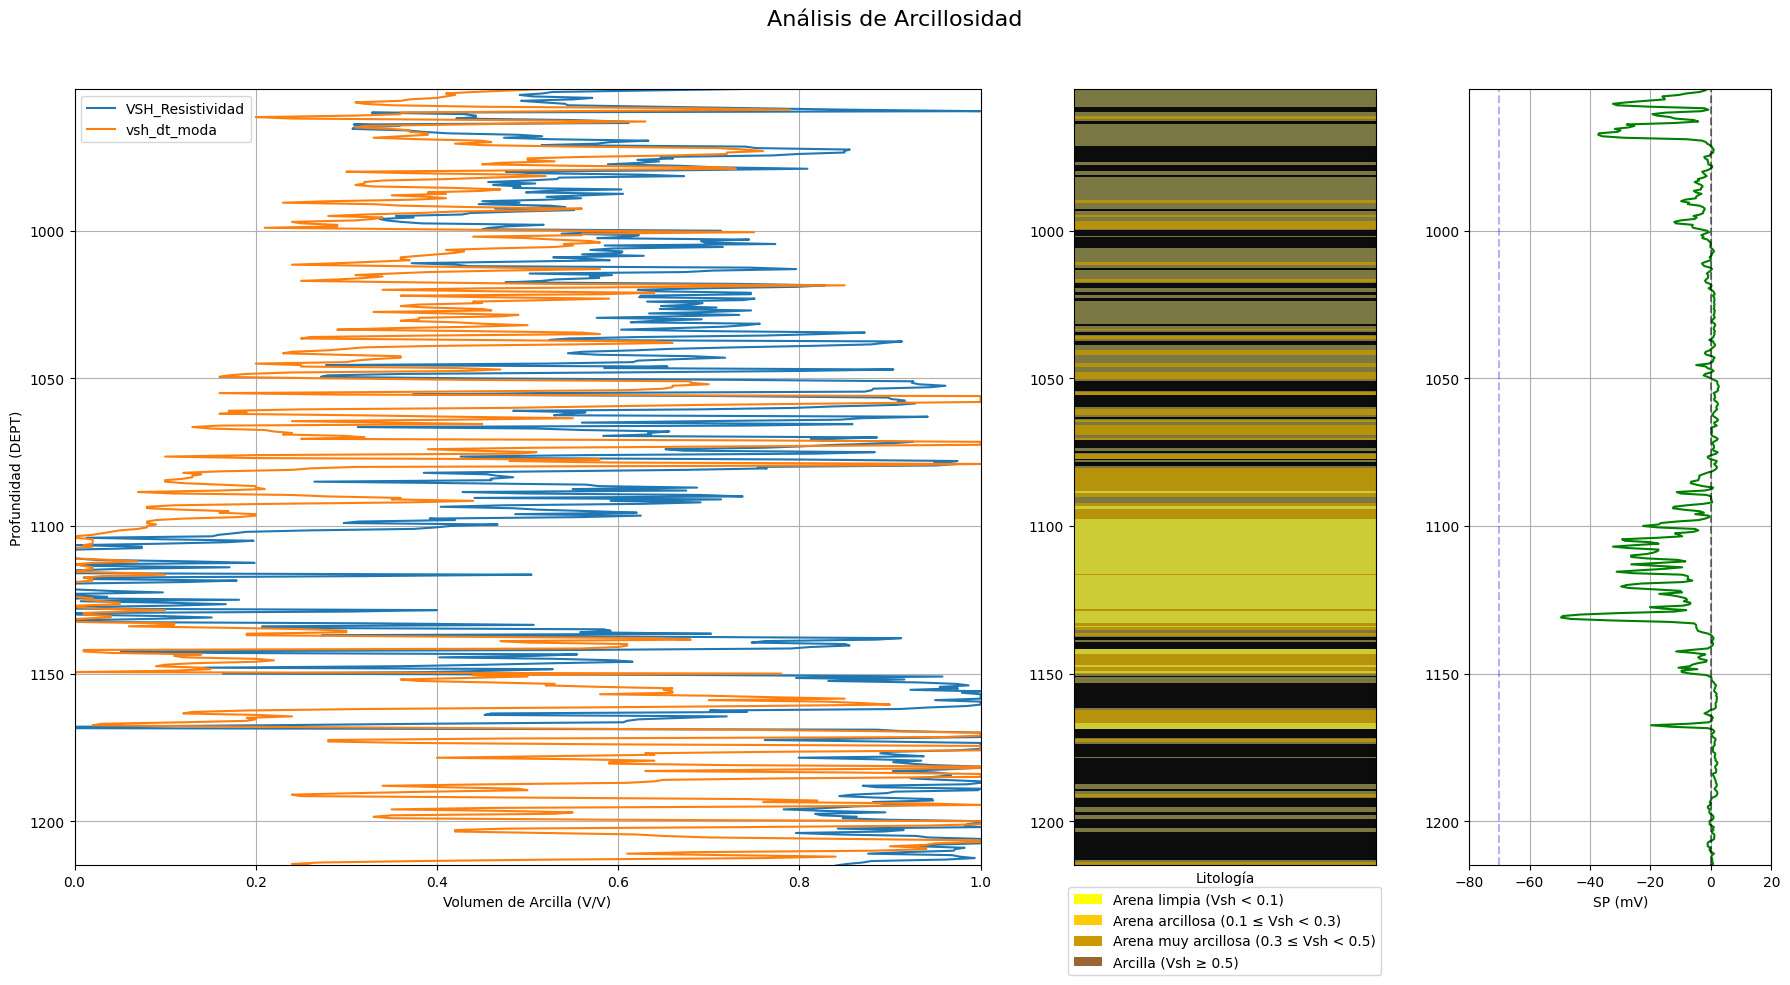

Resultados de zona 0.0 guardados en resultados_zona_0.0.csv

Analizando zona: 1.0

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 2.15 ohm-m
Resistividad de arcilla: 0.78 ohm-m

Cálculo de Vsh con método de tiempo de tránsito sonico:
DT matriz (arena limpia): 98.74 ms/ft
DT arcilla: 133.93 ms/ft


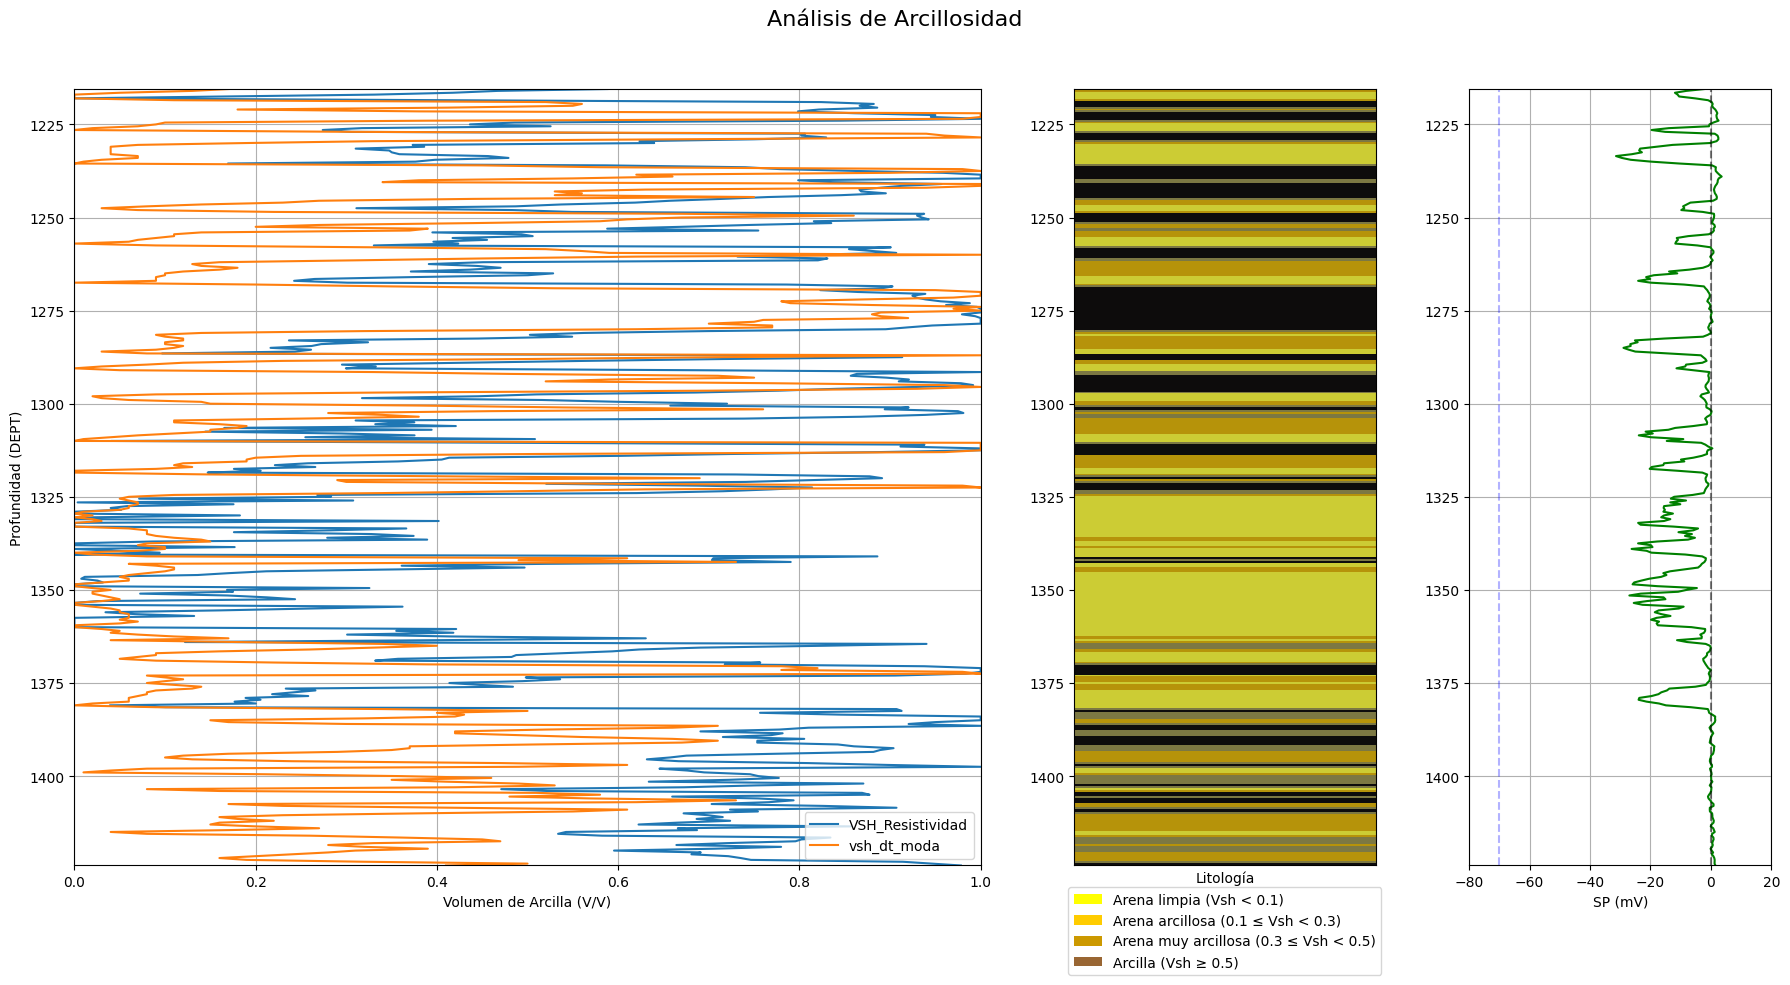

Resultados de zona 1.0 guardados en resultados_zona_1.0.csv

Analizando zona: 2.0

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 4.36 ohm-m
Resistividad de arcilla: 0.73 ohm-m

Cálculo de Vsh con método de tiempo de tránsito sonico:
DT matriz (arena limpia): 88.96 ms/ft
DT arcilla: 121.17 ms/ft


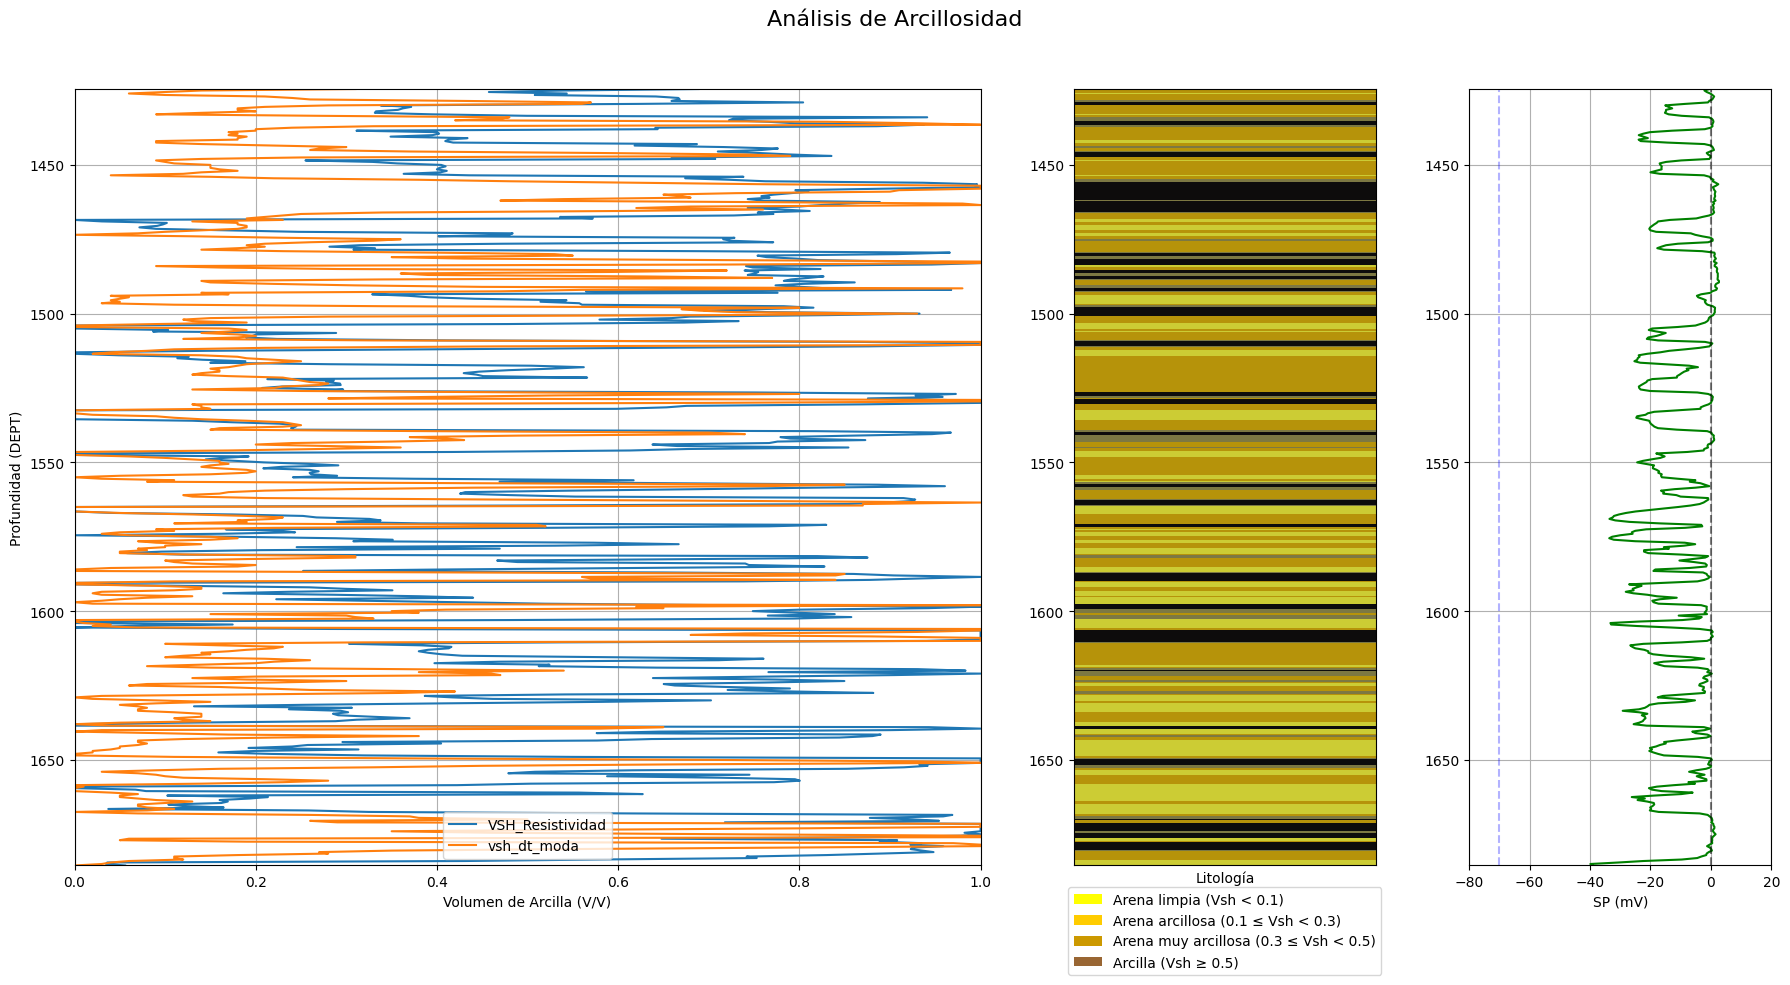

Resultados de zona 2.0 guardados en resultados_zona_2.0.csv

Analizando zona: 3.0

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 8.39 ohm-m
Resistividad de arcilla: 1.35 ohm-m

Cálculo de Vsh con método de tiempo de tránsito sonico:
DT matriz (arena limpia): 79.49 ms/ft
DT arcilla: 111.57 ms/ft


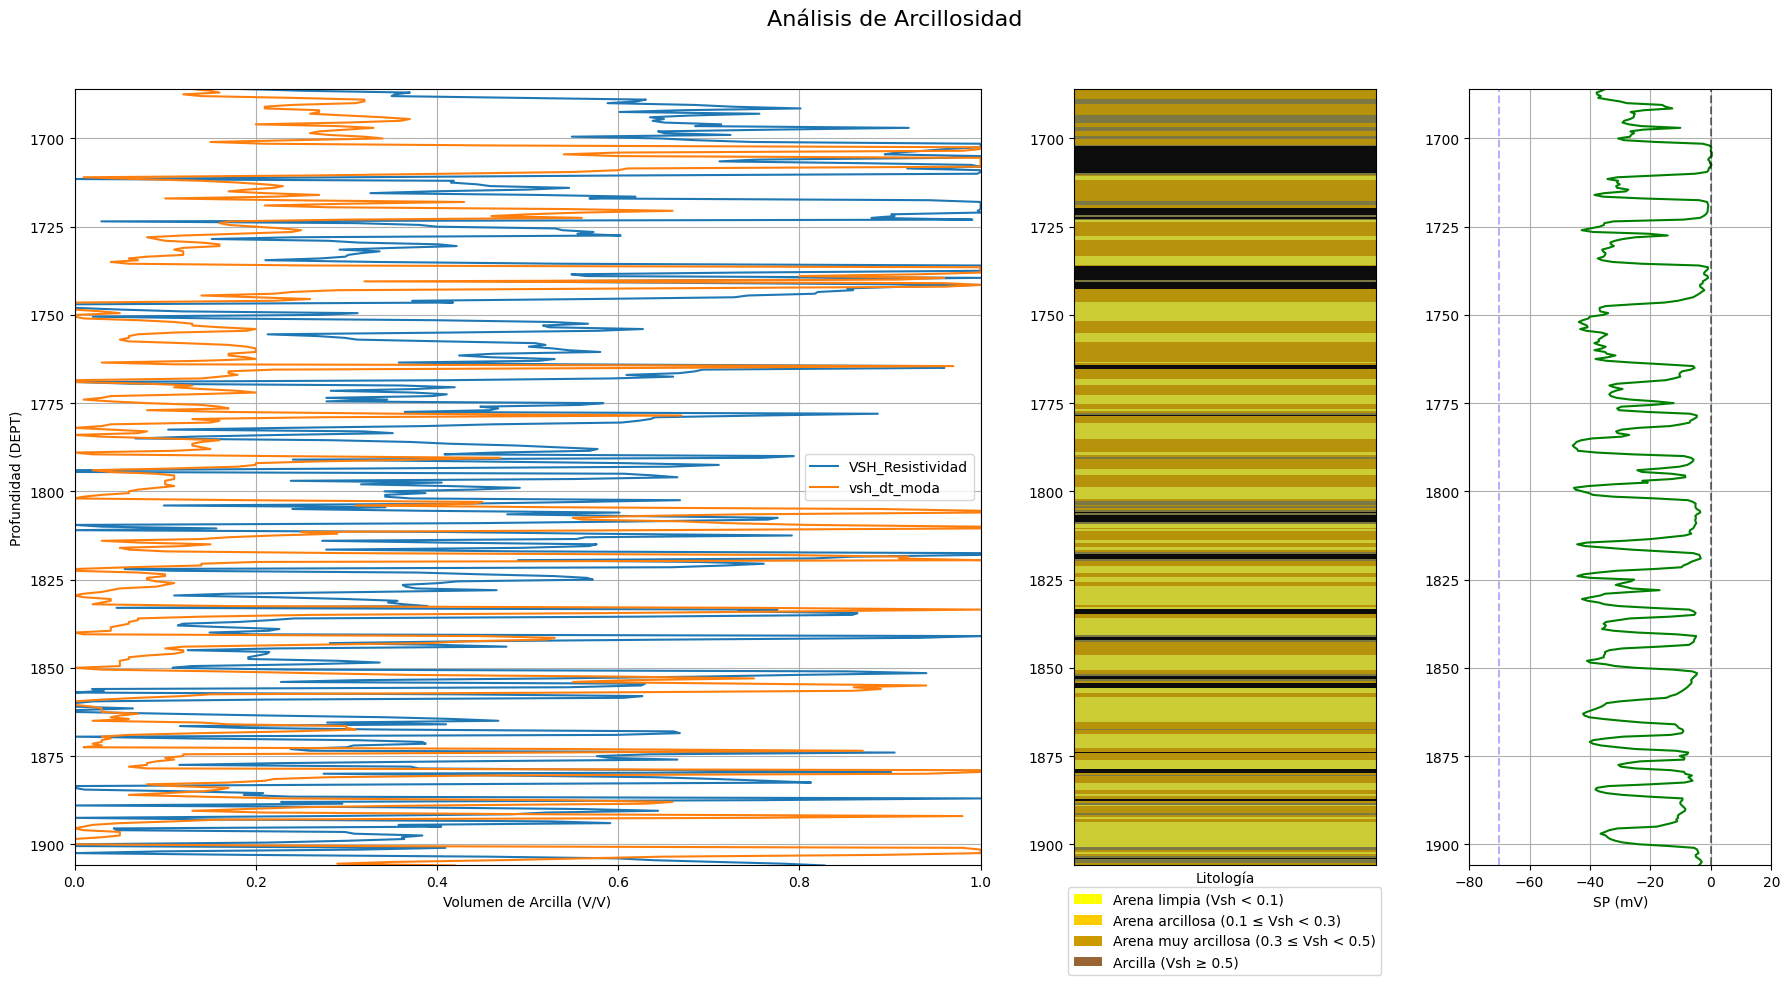

Resultados de zona 3.0 guardados en resultados_zona_3.0.csv

Analizando zona: 4.0

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 15.41 ohm-m
Resistividad de arcilla: 1.08 ohm-m

Cálculo de Vsh con método de tiempo de tránsito sonico:
DT matriz (arena limpia): 75.22 ms/ft
DT arcilla: 110.74 ms/ft


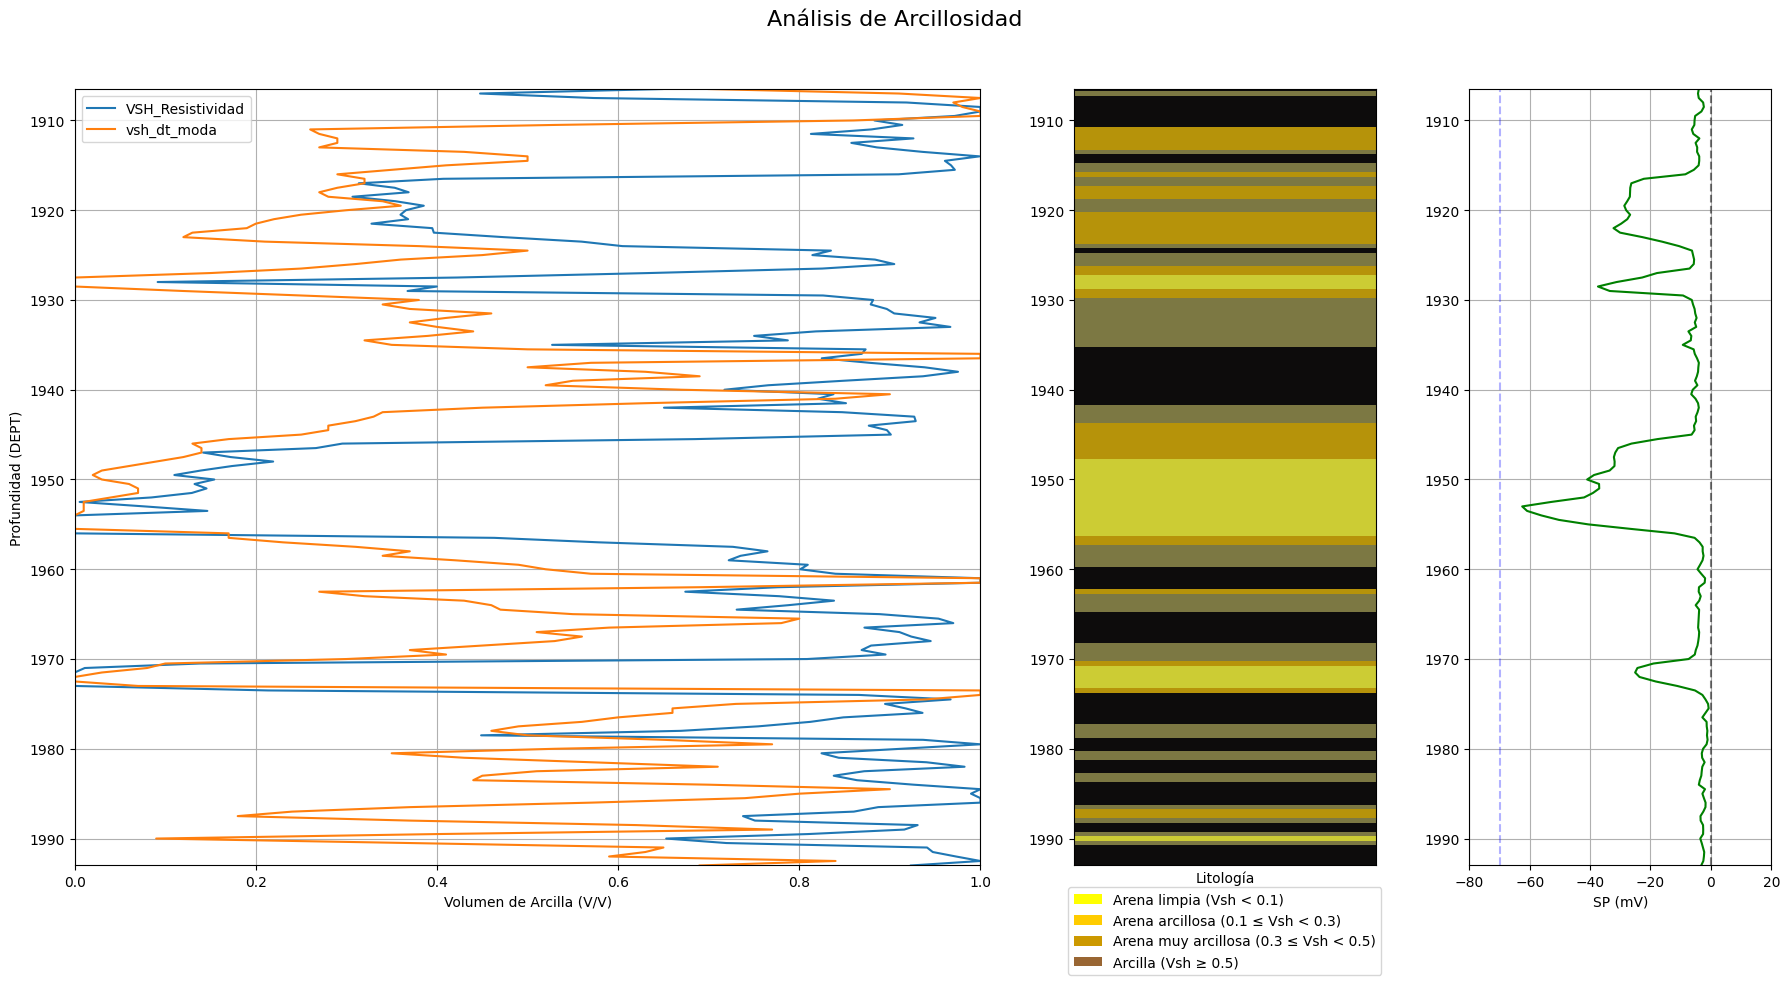

Resultados de zona 4.0 guardados en resultados_zona_4.0.csv

Analizando zona: 10.0

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 6.71 ohm-m
Resistividad de arcilla: 1.02 ohm-m

Cálculo de Vsh con método de tiempo de tránsito sonico:
DT matriz (arena limpia): 86.20 ms/ft
DT arcilla: 107.08 ms/ft


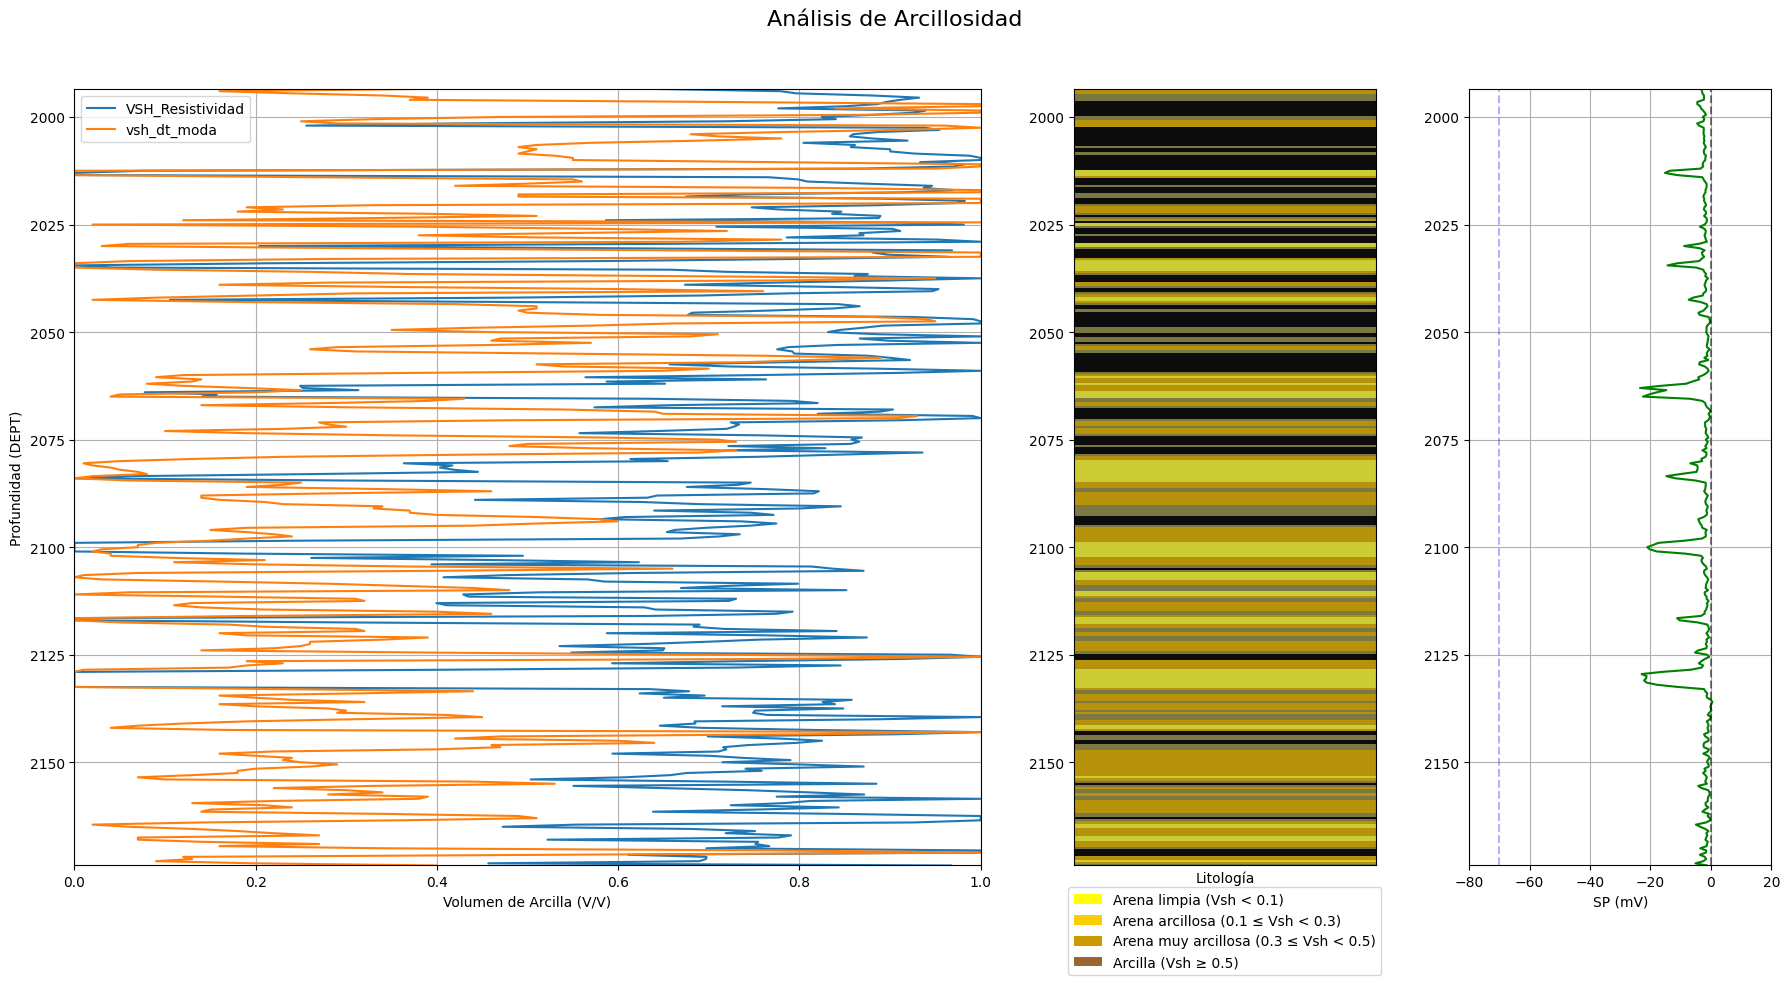

Resultados de zona 10.0 guardados en resultados_zona_10.0.csv

Analizando zona: 14.0

Cálculo de Vsh con método de resistividad:
Resistividad de arena limpia: 12.59 ohm-m
Resistividad de arcilla: 1.52 ohm-m

Cálculo de Vsh con método de tiempo de tránsito sonico:
DT matriz (arena limpia): 73.83 ms/ft
DT arcilla: 92.68 ms/ft


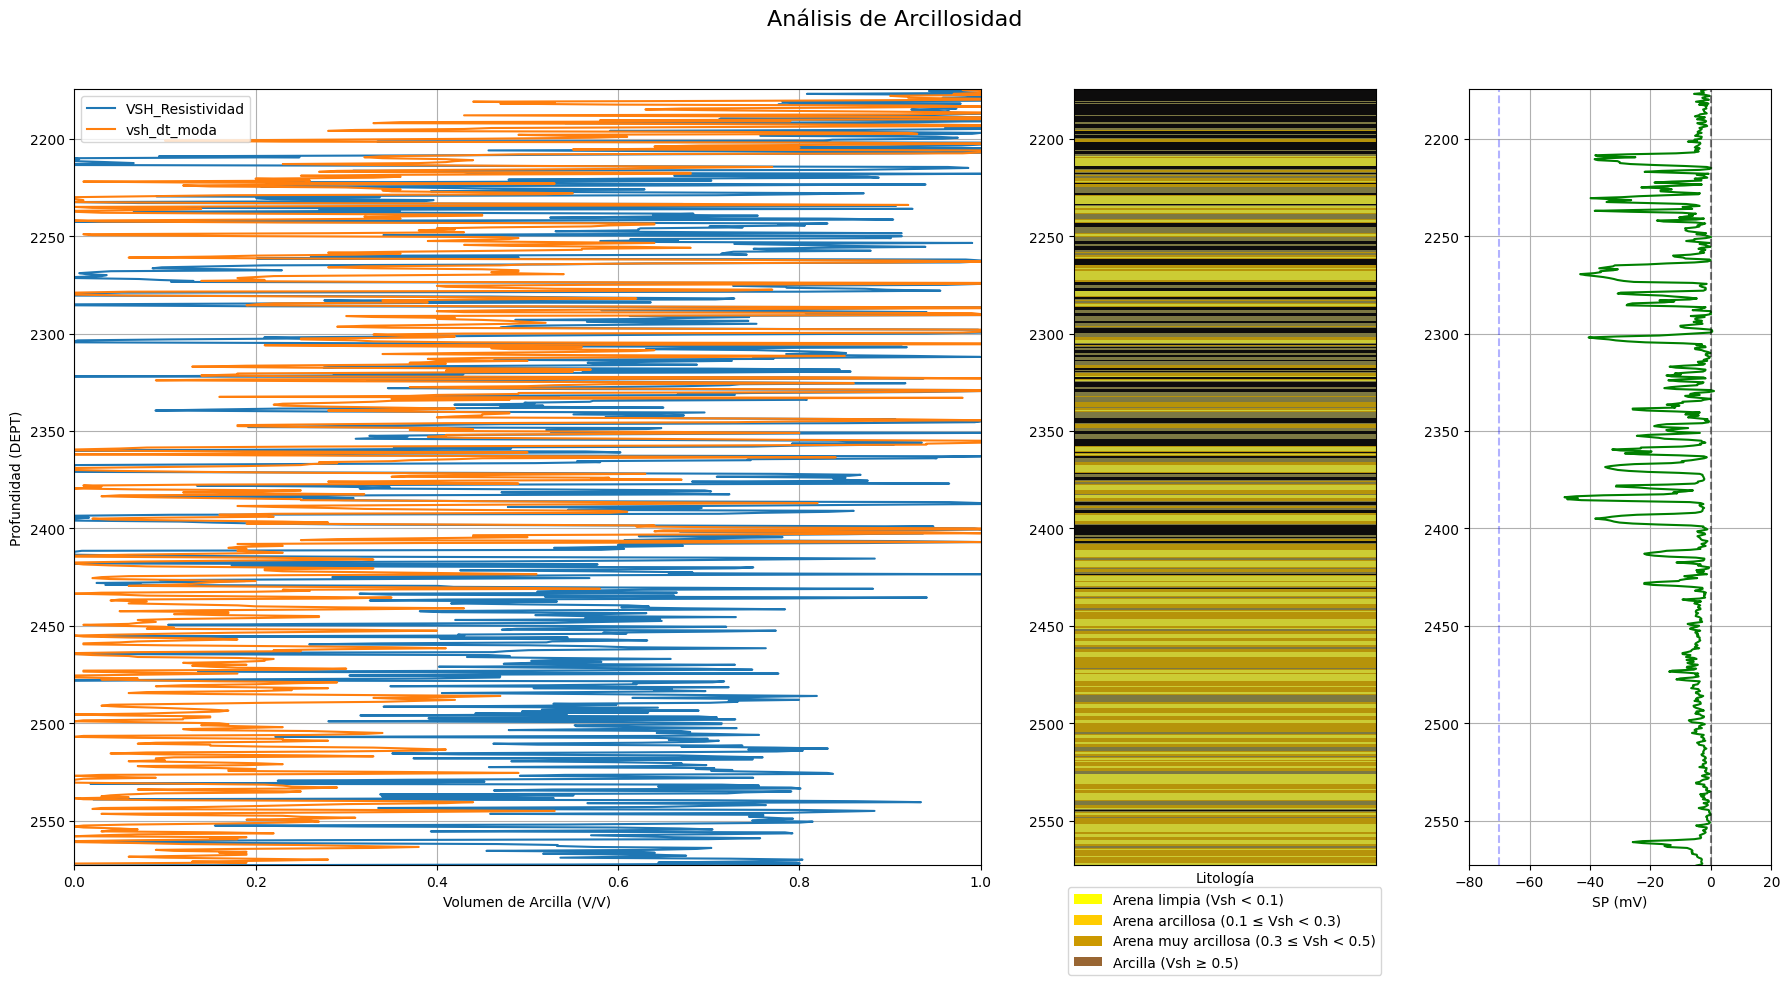

Resultados de zona 14.0 guardados en resultados_zona_14.0.csv
Análisis completado. Resultados guardados en 'resultados_arcillosidad_EN-667.csv


In [65]:
# Ejemplo de uso
if __name__ == "__main__":
    # Ejemplo con datos ficticios
    # En un caso real, reemplaza estos valores con tu archivo y nombres de columnas
    ruta_archivo = "C:\\RepositorioGIT\\Projects2025\\EN-667.csv"
    resultados = analisis_arcillosidad(
        ruta_archivo=ruta_archivo,  # Reemplazar con la ruta real
        prof_col="DEPT",
        gr_col="GR",
        nphi_col="NPHI",
        rhob_col="RHOZ",
        res_col="AT90",     # Columna de resistividad somera
        sp_col="SP",        # Columna de SP
        dt_col="DTCO",        # Columna de tiempo de tránsito sonico
        gr_min=None,        # Opcional, valor mínimo de GR (arena limpia)
        gr_max=None,       # Opcional, valor máximo de GR (arcilla)
        res_arena=None,    # Opcional, resistividad típica de arena limpia (ohm-m)
        res_arcilla=None,  # Opcional, resistividad típica de arcilla (ohm-m)
        dt_matriz= None,  # Opcional, tiempo de tránsito para la matriz (ms/ft)
        dt_arcilla=None,   # Opcional, tiempo de tránsito para la arcilla (ms/ft)
        
    )
    #Extraer nombre de pozo
    nombre_archivo = os.path.basename(ruta_archivo)
    nombre_pozo = os.path.splitext(nombre_archivo)[0]
    
    # Guardar resultados
    resultados.to_csv(f"resultados_arcillosidad{nombre_pozo}.csv", index=False, sep=" ")
    print(f"Análisis completado. Resultados guardados en 'resultados_arcillosidad_{nombre_pozo}.csv")